<a href="https://colab.research.google.com/github/vidyaana22/portofolio-dataanalyst/blob/main/Text%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nama    : Vidyana Yulianingrum**

**NIM     : 162112133002**

**Praktikum 8 - Text Classification Inggris**

# **Import Dataset**

In [ ]:
import pandas as pd
df = pd.read_csv('economic.csv', encoding = 'ISO-8859-1')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,unit_id,golden,unit_state,trusted_judgments,last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,article_id,date,headline,text
0,842613455,False,finalized,3,12/5/2015 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/1991,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/2015 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/2007,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/2015 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/1991,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/2015 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/1986,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/2015 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/2002,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...


In [ ]:
df = df[["text","relevance"]]

# **Visualisasi Data sebelum Preprocessing**

In [ ]:
df['text'] = df['text'].fillna('').astype(str)
print(type(df['text']))

<class 'pandas.core.series.Series'>


<ipython-input-3-4321feca3eb3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].fillna('').astype(str)


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
tx = []
for i in range(0, len(df)):
  data = df["text"][i]
  tx.append(data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.tokenize import word_tokenize
tokens = []
for text in tx:
    tokens.extend(word_tokenize(text))

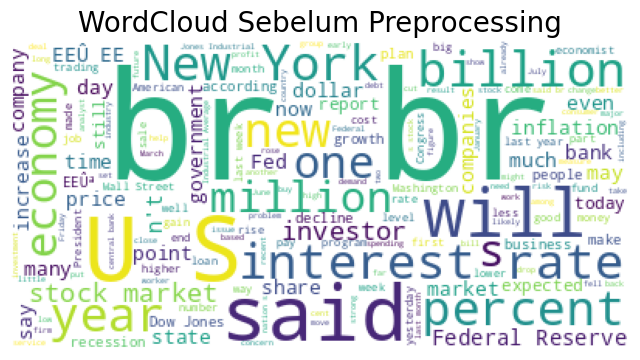

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

token = ' '.join(tokens)
wordcloud = WordCloud(background_color = "white").generate(token)

#Plot the wordcloud
plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)

#To remove the axis value
plt.axis("off")
plt.title('WordCloud Sebelum Preprocessing', fontsize=20)
plt.show()

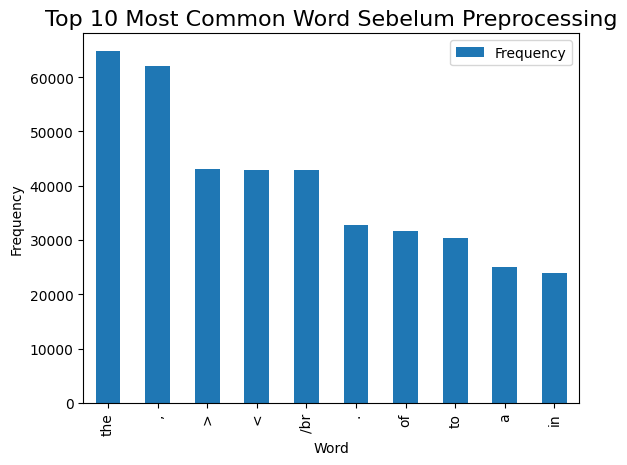

In [ ]:
from nltk.probability import FreqDist
fdist = FreqDist(tokens)
fdistc = fdist.most_common(10)

df_freq_tokens = pd.DataFrame.from_dict(dict(fdistc), orient = 'index')
df_freq_tokens.columns = ['Frequency']
df_freq_tokens.index.name = 'Key'
df_freq_tokens.plot(kind = 'bar')

plt.title('Top 10 Most Common Word Sebelum Preprocessing', fontsize = 16)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

# **Preprocessing Data**

In [ ]:
import re
from bs4 import BeautifulSoup
import unicodedata

# General preprocessing
def general_prep(text):
    text = text.strip().lower()   # Case folding & trimming whitespace di awal dan akhir
    text = unicodedata.normalize('NFKD', text) # Ubah styled text menjadi biasa
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Hapus URLs
    return text

# Non-ASCII elements
def del_nonascii(text):
    return ''.join(char for char in text if ord(char) < 128)

# Emoticon handler
def del_emoticons(text):
    emoticon_ranges = [
        '\U0001F600-\U0001F64F', '\U0001F300-\U0001F5FF', '\U0001F680-\U0001F6FF',
        '\U0001F700-\U0001F77F', '\U0001F780-\U0001F7FF', '\U0001F800-\U0001F8FF',
        '\U0001F900-\U0001F9FF', '\U0001FA00-\U0001FA6F', '\U0001FA70-\U0001FAFF',
        '\U0001FB00-\U0001FBFF', '\U0001FC00-\U0001FCFF', '\U0001FD00-\U0001FDFF',
        '\U0001FE00-\U0001FEFF', '\U0001FF00-\U0001FFFF']

    emoticon_pattern = r'[' + '|'.join(emoticon_ranges) + ']+'
    return re.sub(emoticon_pattern, '', text)

# Twitter elements
def twitter_prep(text):
    text = re.sub(r'#\w+', '', text)   # Hapus hashtags
    text = re.sub(r'@\w+', '', text)   # Hapus mentions

# Hapus tag
def del_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Hapus isi teks di dalam kurung siku
def del_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Final elements preprocessing
def final_prep(text, remove_digits=False):
    text = text.replace("\n", " ")   # Menggantikan \n dengan spasi

    # Hapus simbol
    if remove_digits:
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)   # Kalau True, hapus angka juga
    else:
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    text = re.sub(' +', ' ', text)   # Menghapus repetitive spaces
    return text

# Penyatuan fungsi prepro yang diperlukan
def prepo(text):
    text = general_prep(text)
    text = del_nonascii(text)
    text = del_emoticons(text)
    text = del_html_tags(text)
    text = del_between_square_brackets(text)
    text = final_prep(text)
    return text

# Apply function
df['text'] = df['text'].apply(prepo)

<ipython-input-8-6ea483e78086>:35: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
df.head()

,text,relevance
0,new york yields on most certificates of deposi...,yes
1,the wall street journal onlinethe morning brie...,no
2,washington in an effort to achieve banking ref...,no
3,the statistics on the enormous costs of employ...,no
4,new york indecision marked the dollar s tone a...,yes


## **Slang**

In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}
slangword = pd.DataFrame(list(abbreviations.items()), columns=['slang', 'formal'])
slangword.to_csv('slangword.csv', index=False)

In [ ]:
slangword = pd.read_csv('slangword.csv')

def replace_slang_word(doc, slang_word):
    words = doc.split()
    new_words = []

    for word in words:
        if word in slang_word['slang'].values:
            formal = slang_word[slang_word['slang'] == word]['formal'].values
            if len(formal) == 1:
                new_words.append(formal[0])
            else:
                new_words.append(word)
        else:
            new_words.append(word)

    return ' '.join(new_words)

# Assuming 'text' is a list containing your text
df['text'] = df['text'].apply(lambda doc: replace_slang_word(doc, slangword))

In [ ]:
df.head()

,text,relevance
0,new york yields on most certificates of deposi...,yes
1,the wall street journal onlinethe morning brie...,no
2,washington in an effort to achieve banking ref...,no
3,the statistics on the enormous costs of employ...,no
4,new york indecision marked the dollar s tone a...,yes


## **Stopwords**

In [ ]:
from nltk import word_tokenize
from nltk.corpus import stopwords

stopwords_list = set(stopwords.words('english'))

#removing the stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [t for t in tokens if t not in stopwords_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

#Apply function
df['text'] = df['text'].apply(remove_stopwords)

In [ ]:
df.head()

,text,relevance
0,new york yields certificates deposit offered m...,yes
1,wall street journal onlinethe morning brief lo...,no
2,washington effort achieve banking reform senat...,no
3,statistics enormous costs employee drug abuse ...,no
4,new york indecision marked dollar tone traders...,yes


## **Stemming**

In [ ]:
from nltk.stem.snowball import SnowballStemmer

def snowball_stemmer(text):
    stemmer = SnowballStemmer('english')
    text= ' '.join([stemmer.stem(word) for word in text.split()])
    return text

#Apply function on review column
df['text'] = df['text'].apply(snowball_stemmer)

In [ ]:
df.head()

,text,relevance
0,new york yield certif deposit offer major bank...,yes
1,wall street journal onlineth morn brief look d...,no
2,washington effort achiev bank reform senat neg...,no
3,statist enorm cost employe drug abus well know...,no
4,new york indecis mark dollar tone trader paus ...,yes


# **Visualisasi Hasil Preprocessing**

In [ ]:
tx = df['text']
from nltk.tokenize import word_tokenize
tokens = []
for text in tx:
    tokens.extend(word_tokenize(text))

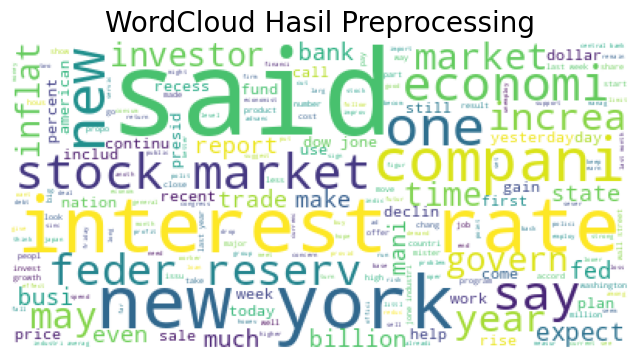

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

token = ' '.join(tokens)
wordcloud = WordCloud(background_color = "white").generate(token)

#Plot the wordcloud
plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)

#To remove the axis value
plt.axis("off")
plt.title('WordCloud Hasil Preprocessing', fontsize=20)
plt.show()

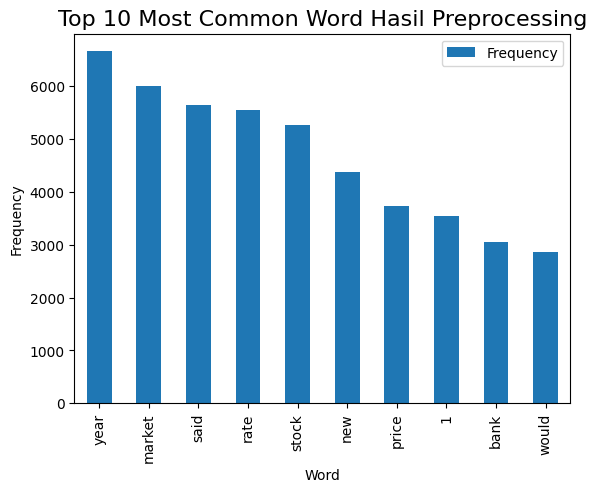

In [ ]:
from nltk.probability import FreqDist
fdist = FreqDist(tokens)
fdistc = fdist.most_common(10)

df_freq_tokens = pd.DataFrame.from_dict(dict(fdistc), orient = 'index')
df_freq_tokens.columns = ['Frequency']
df_freq_tokens.index.name = 'Key'
df_freq_tokens.plot(kind = 'bar')

plt.title('Top 10 Most Common Word Hasil Preprocessing', fontsize = 16)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

# **Term Weighting dengan Word2Vec**

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# Tokenisasi dan pembersihan teks (langkah 1)
corpus = df['text'].apply(lambda x: x.split())

# Membuat model Word2Vec (langkah 2)
model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, sg=0)

# Membuat vektor untuk setiap kalimat
def get_vector(tokens, model, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

# Mengonversi kata ke angka
wordvec_arrays = np.zeros((len(corpus), 100))
for i in range(len(corpus)):
    wordvec_arrays[i, :] = get_vector(corpus[i], model, 100)

In [ ]:
wordvec_arrays[0]

array([ 0.39218077,  0.96184643,  0.61952016, -0.03998816, -0.31916442,
       -0.73517783,  0.1998207 ,  1.09774435, -0.15340206, -0.3394367 ,
       -0.0632527 , -0.85869415,  0.3212749 ,  0.19246177,  0.25559895,
       -0.12108653,  0.35688957,  0.2334686 , -0.10014103, -1.12272508,
        0.46289563,  0.2001555 ,  0.29400569, -0.53408573, -0.34360336,
        0.43309502, -0.33515109, -0.77371477, -0.35531068,  0.06593838,
        0.08090085, -0.0993998 ,  0.50153756, -1.16029404, -0.14215372,
        0.02710969,  0.23694228, -0.54628042, -0.13056842, -0.68312915,
        0.11393187,  0.00618415,  0.45263337, -0.27994075,  0.05394536,
       -0.34852129, -0.49671096, -0.71518505,  0.87422567,  0.13879152,
        0.03448583, -0.4021767 , -0.31924167, -0.36280616,  0.70699831,
       -0.04000828,  0.62971933,  0.41833463, -0.55523641, -0.06373062,
        0.38337625, -0.42678109, -0.18412246,  0.21138959, -0.4372105 ,
        0.40294879,  0.17226906,  0.33384001, -0.60198729, -0.07

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Get the feature columns and target column
X = wordvec_arrays
y = df['relevance']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LabelBinarizer
le = LabelEncoder()

# Transform relevance into binary format
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# **Classification**

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300)
clf = clf.fit(x_train, y_train)

predict_clf = clf.predict(x_test)

In [ ]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
nb = GaussianNB()
nb = nb.fit(x_train, y_train)

predict_nb = nb.predict(x_test)

In [ ]:
#SVM
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm = svm.fit(x_train, y_train)

predict_svm = svm.predict(x_test)

In [ ]:
#Logictic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
lr = lr.fit(x_train, y_train)

predict_lr = lr.predict(x_test)

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn = knn.fit(x_train, y_train)

predict_knn = knn.predict(x_test)

# **Evaluasi Metric**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

clf_eval = classification_report(y_test, predict_clf)
print(clf_eval)

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1310
           1       0.00      0.00      0.00         3
           2       0.50      0.04      0.07       286

    accuracy                           0.82      1599
   macro avg       0.44      0.34      0.32      1599
weighted avg       0.76      0.82      0.75      1599



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
nb_eval = classification_report(y_test, predict_nb)
print(nb_eval)

              precision    recall  f1-score   support

           0       0.88      0.69      0.77      1310
           1       0.00      0.00      0.00         3
           2       0.30      0.48      0.37       286

    accuracy                           0.65      1599
   macro avg       0.39      0.39      0.38      1599
weighted avg       0.77      0.65      0.70      1599



In [ ]:
svm_eval = classification_report(y_test, predict_svm)
print(svm_eval)

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1310
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00       286

    accuracy                           0.82      1599
   macro avg       0.27      0.33      0.30      1599
weighted avg       0.67      0.82      0.74      1599



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
lr_eval = classification_report(y_test, predict_lr)
print(lr_eval)

              precision    recall  f1-score   support

           0       0.82      0.98      0.90      1310
           1       0.00      0.00      0.00         3
           2       0.38      0.05      0.08       286

    accuracy                           0.81      1599
   macro avg       0.40      0.34      0.33      1599
weighted avg       0.74      0.81      0.75      1599



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
knn_eval = classification_report(y_test, predict_knn)
print(knn_eval)

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1310
           1       0.00      0.00      0.00         3
           2       0.37      0.14      0.20       286

    accuracy                           0.80      1599
   macro avg       0.40      0.36      0.36      1599
weighted avg       0.75      0.80      0.76      1599



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Cross Validation**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#Model Terbaik dengan Random Forest
param_grid = {
    'n_estimators': [100, 300],  # Jumlah pohon
    'max_depth': [None, 5],  # Kedalaman maksimum pohon
    'min_samples_split': [2, 5]  # Jumlah sampel minimum untuk membagi node
}

# Inisialisasi GridSearchCV untuk cross-validation dan fine-tuning
grid_search = GridSearchCV(clf, param_grid, cv = 5)  # cv=5 untuk 5-fold cross-validation

# Melakukan fine-tuning model menggunakan data
grid_search.fit(x_train, y_train)

# Menampilkan parameter terbaik
print("Parameter terbaik:", grid_search.best_params_)

# Menampilkan skor validasi silang terbaik
print("Skor validasi silang terbaik:", grid_search.best_score_)

Parameter terbaik: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}
Skor validasi silang terbaik: 0.8226739640344019


# **Visualisasi**

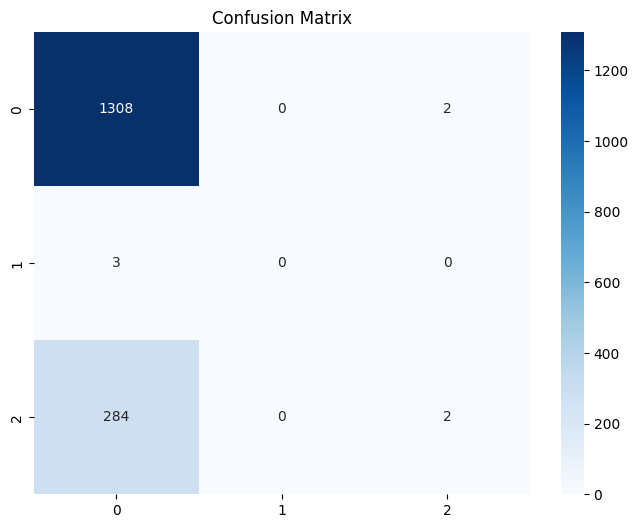

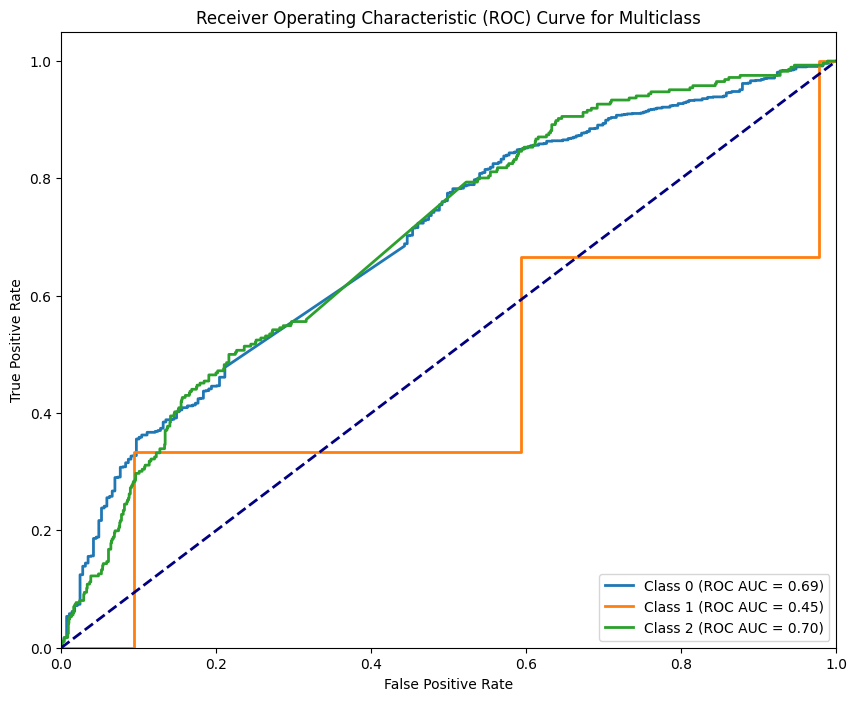

Best Hyperparameters:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy Score: 0.82
F1 Score: 0.82


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=300, max_depth=5, min_samples_split=2)

# Train the model
rf_model.fit(x_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(x_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Calculate ROC Curves for Multiclass Classification
y_scores = rf_model.predict_proba(x_test)
n_classes = len(rf_model.classes_)

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (ROC AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.show()

# Print the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)

# Accuracy Score
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score: {:.2f}".format(rf_accuracy))

# F1 Score for multiclass classification
rf_f1 = f1_score(y_test, y_pred, average='micro')  # or 'macro', 'weighted', or None
print("F1 Score: {:.2f}".format(rf_f1))

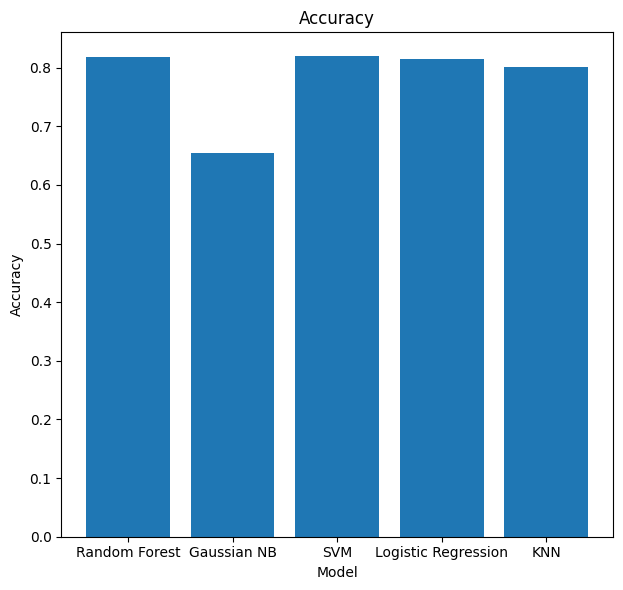

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Inisialisasi model-model
models = {
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=5, min_samples_split=2),
    "Gaussian NB": GaussianNB(),
    "SVM": SVC(kernel='linear'),
    "Logistic Regression": LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors = 5)
}

# List untuk menyimpan hasil akurasi dan f1-score
accuracy_scores = []

# Melakukan training, prediksi, dan evaluasi untuk setiap model
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Labels untuk model
model_names = list(models.keys())

# Plot akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(model_names, accuracy_scores)
plt.title('Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()